In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format
#pd.set_option('display.max_rows', None)

from model_SARIMA import build_SARIMA, optimal_orders
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from test_normal import hist_plot
from time_series import seasonal_plot, seasonal_subseries_plot, acf_plot, lag_plot, decompose
from cross_validation import cross_validation_SARIMA, cross_validation_naive


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 1
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

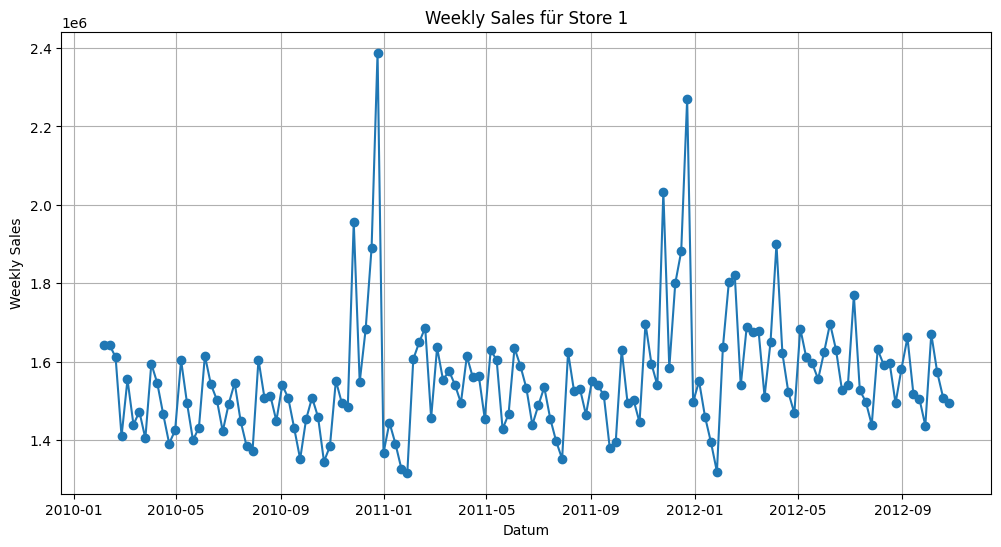

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

SARIMA Modell

In [6]:
sarima_params  = optimal_orders.get(str(store_number))
order = tuple(sarima_params["order"])
seasonal_order = tuple(sarima_params["seasonal_order"])

sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         weekly_sales   No. Observations:                  143
Model:             SARIMAX(6, 1, 0)x(1, 0, [1], 52)   Log Likelihood               -1876.785
Date:                              Thu, 20 Mar 2025   AIC                           3771.571
Time:                                      18:39:36   BIC                           3798.173
Sample:                                  02-05-2010   HQIC                          3782.381
                                       - 10-26-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3478      0.080     -4.353      0.000      -0.504      -0.191
ar.L2         -0.2699      0.100     -2.688      0.007      -0.467      -0.073
ar.L3         -0.2690      0.122     -2.199      0.028      -0.509      -0.029
ar.L4         -0.0378      0.141     -0.269      0.788      -0.313       0.238
ar.L5         -0.2032      0.097     -2.093      0.036      -0.394      -0.013
ar.L6         -0.1277      0.071     -1.800      0.072      -0.267       0.011
ar.S.L52       0.6849      0.331      2.072      0.038       0.037       1.333
ma.S.L52      -0.2939      0.434     -0.677      0.498      -1.144       0.556
sigma2      2.116e+10   5.49e-11   3.85e+20      0.000    2.12e+10    2.12e+10
===================================================================================
Ljung-Box (L1) (Q):                   4.34   Jarque-Bera (JB):                89.12
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.76e+36. Standard errors may be unstable.
"""

Naives Modell

In [7]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Modell wählen

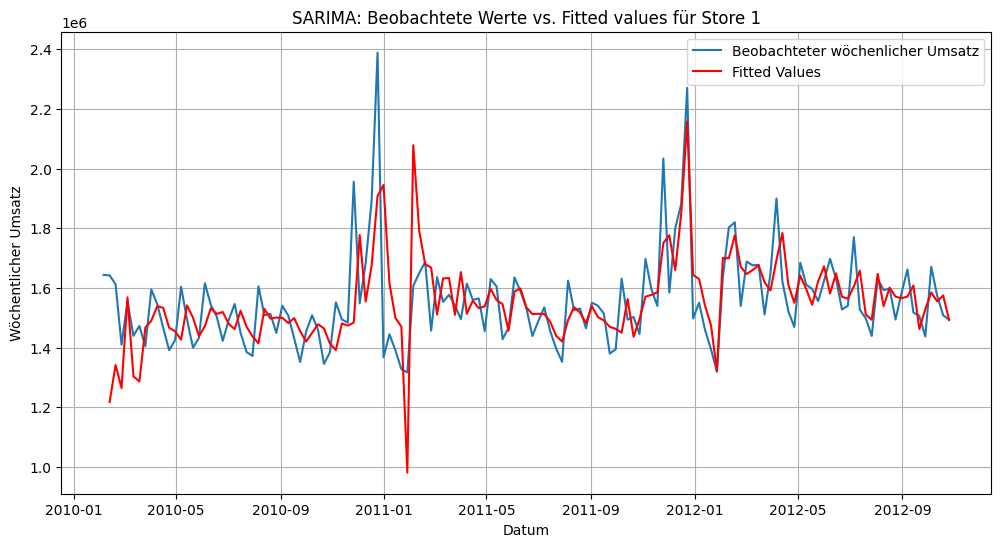

In [8]:
#residuen = naiv_resid
#fitted_values = naiv_fitted

residuen = sarima_model.resid
fitted_values = sarima_model.fittedvalues
residuen = residuen.iloc[1:]
fitted_values = fitted_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelation Tests

Box Pierce: 0.1321
Ljung Box: 0.1073
Breusch Godfrey: 0.8340
Run Test: 0.2822
Durbin Watson: 2.2348


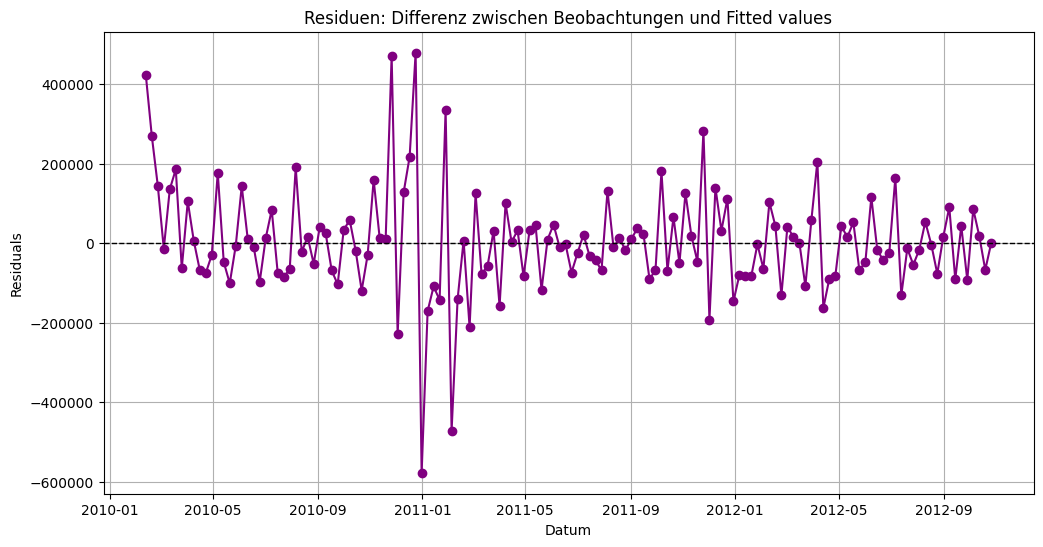

<Figure size 1200x600 with 0 Axes>

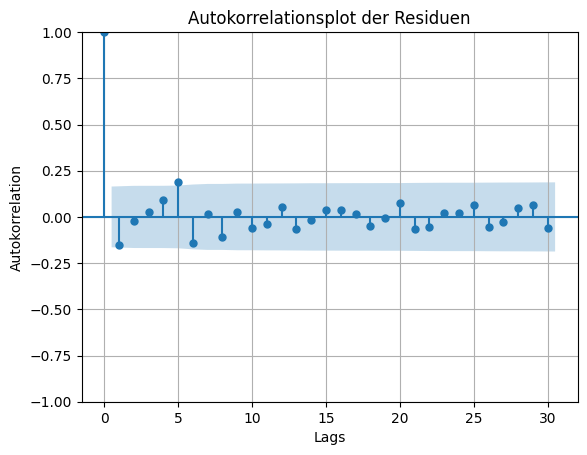

In [9]:
box_pierce_test(residuen)
ljung_box_test(residuen)
breusch_godfrey_test(residuen)
run_test(residuen)

durbin_watson_test(residuen)

residual_plot(residuen)
acf_resid_plot(residuen)


Mittelwert Tests

Mittelwert der Residuen: 3114.8306
T-Test: 0.7835
Wilcoxon Test: 0.6786
Binomial Test: 0.8013
Kolmogorov Test: 0.0209


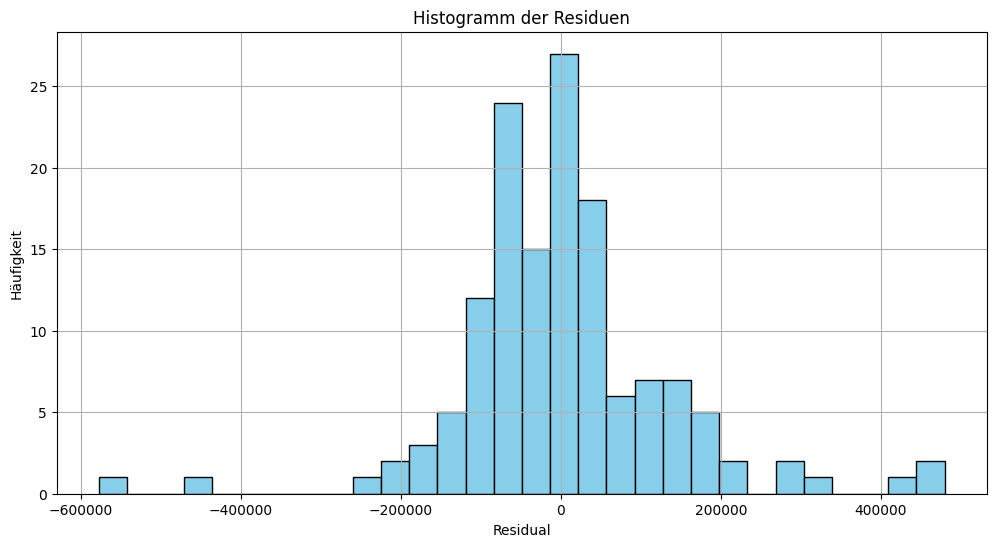

In [10]:
mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")

t_test(residuen)
wilcoxon_test(residuen)
binomial_test(residuen)
kolmogorov_test(residuen)

hist_plot(residuen)


Kreuz Validierung

In [11]:
cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#cv_df = cross_validation_naive(sales)


KeyboardInterrupt: 

Korrelations Tests

Box Pierce: 0.0352
Ljung Box: 0.0084
Breusch Godfrey: 1.0000
Run Test: 0.9275
Durbin Watson: 2.1771


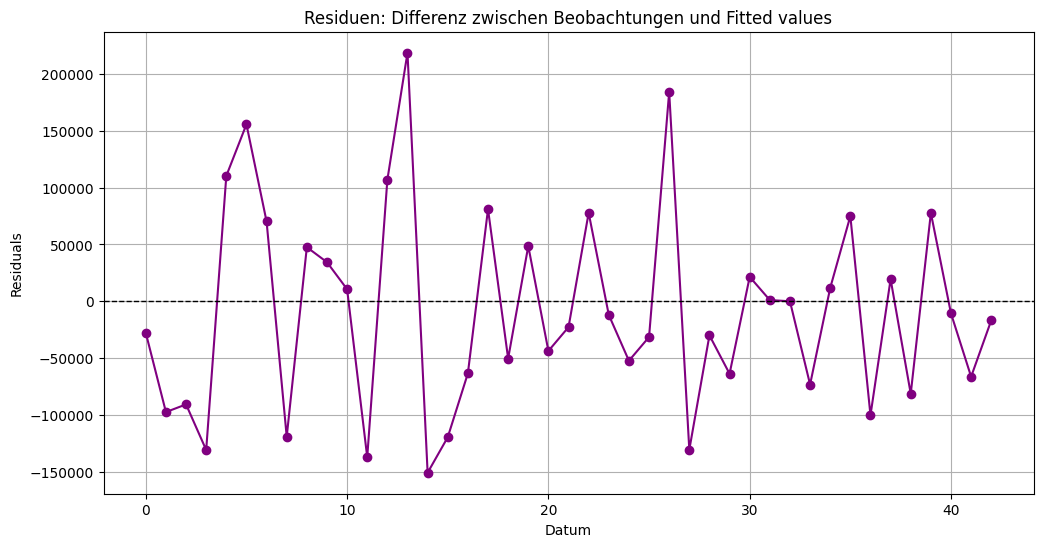

<Figure size 1200x600 with 0 Axes>

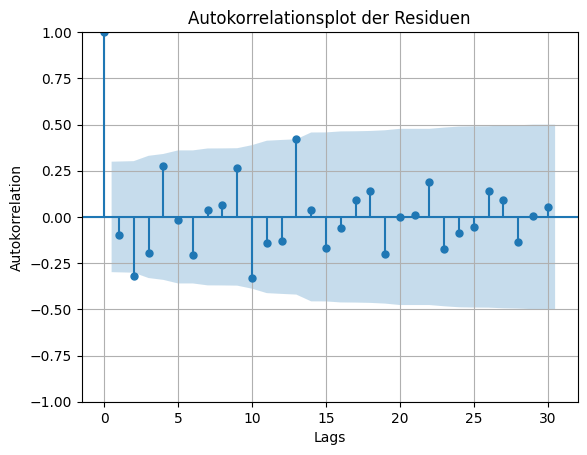

In [ ]:
errors = cv_df['error']

box_pierce_test(errors)
ljung_box_test(errors)
breusch_godfrey_test(errors)
run_test(errors)

durbin_watson_test(errors)

residual_plot(errors)
acf_resid_plot(errors)

Mittelwert Tests

Mittelwert der Errors: 14731.087421449483
T-Test: 0.5288
Wilcoxon Test: 0.3656
Binomial Test: 0.5424
Kolmogorov Test: 0.9819


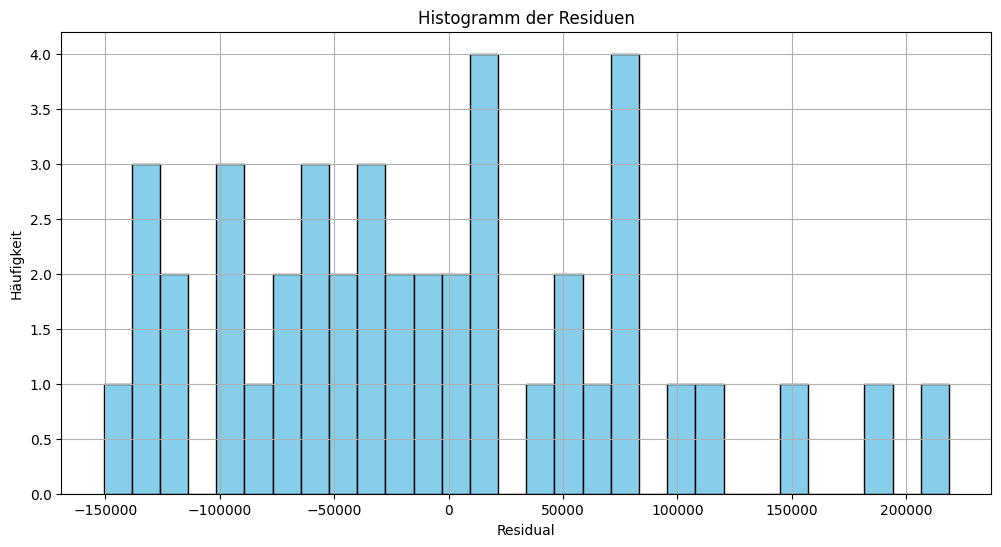

In [ ]:
mean_errors = errors.mean()
print(f'Mittelwert der Errors: {mean_resid}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)
